# Note
This notebook can be run on google colab for improved performance. The code changes necessary for running on this system are commented over the code.

## Data preprocessing

In [33]:
! pip install \
  scprep\
  spacy==2.3.2 \
  sentence_transformers==0.4.0 \
  phate==1.0.4 && \
  python -m spacy download es_core_news_lg

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_lg')


<span style="color:red"><strong>WARNING!</strong></span> Once you installed the packages in the previous cell you must restart your runtime and then import the library and load the model

In [1]:
import spacy
if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [2]:
!rm -rf policy-data-analyzer/

In [ ]:
# Define branch to clone
! branch_name='#50_dfq_sbert_fine_tuning' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

In [4]:
import pandas as pd
import sys
import os
import csv
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from torch import nn, Tensor
from typing import Iterable, Dict
from torch.utils.data import DataLoader
import math
import time
import cupy as cp
import json

os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error
from tasks.data_loader.src.utils import *
from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.data_augmentation.src.zero_shot_classification.fine_tuning_sbert import *
from tasks.evaluate_model.src.model_evaluator import *
from tasks.data_visualization.src.plotting import *

from google.colab import drive
drive.mount('/content/drive')

Using the GPU
Mounted at /content/drive


## Run fine tuning experiments

### Data Loading

In [19]:
experiment = "EXP17"
classifier = "Multiclass"

# This first one is the one used by David and Daniel
base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

# This one is the one used by Jordi
# base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/datasets/{classifier}/"
results_save_path = f"{base_path}/Modeling/MulticlassClassificationExperiments/TESTS/{experiment}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
  
train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
print("Label names:", label_names)
print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

Label names: ['Supplies', 'Direct payment', 'Credit', 'Tax deduction', 'Technical assistance', 'Fine']
Train Sentence: La cantidad y tipo de plantas, producidas en los viveros comunitarios, así como el período de siembra, estarán definidas en función al sistema agroforestal y en los planes de trabajo elaborados por las/los Técnicos(as) en conjunto con las/los sujetos de derecho. 
Train Label: Supplies
Test Sentence: La metodología para la determinación del valor inicial de pago y el valor final de pago de la libra de azúcar a pagar a los productores se establecerá en el "Reglamento del Sistema de Pago de Caña de Azúcar". 
Test Label: Direct payment


### Define evaluation classifier (optional)
If using a sklearn or other non-SBERT model as a classifier for evaluation, uncomment one of these models (or add your own and name it `clf`)

In [20]:
# clf = LGBMClassifier(n_estimators=2000,
#                       feature_fraction=0.06,
#                       bagging_fraction=0.67,
#                       bagging_freq=1,
#                       verbose=0,
#                       n_jobs=6,
#                       random_state=69420)

# clf = svm.SVC(gamma=0.001, C=100.)

# clf = RandomForestClassifier(n_estimators=500,
#                             max_features=0.06,
#                             n_jobs=6,
#                             random_state=69420)

### Grid Search Fine Tuning

Stores only the parameters used in the grid search, together with the results - no model is stored

In [24]:
grid_search_params = {
    "all_test_perc": [0.15],# 0.2, 0.25, 0.3],
    "model_names": ['stsb-xlm-r-multilingual'],# 'paraphrase-xlm-r-multilingual-v1'], #, 'quora-distilbert-multilingual''distiluse-base-multilingual-sed-v2',
    "output_path": results_save_path,
    "experiment": experiment,
    # If you want to train for a set number of epochs instead of a range, set all these numbers to be equal
    "start_epochs": 2, 
    "epochs_increment": 2,
    "max_num_epochs": 2
}

Grid Search Fine tuning parameters:
 {
    "all_test_perc": [
        0.15
    ],
    "model_names": [
        "stsb-xlm-r-multilingual"
    ],
    "output_path": "/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17",
    "experiment": "EXP17",
    "start_epochs": 2,
    "epochs_increment": 2,
    "max_num_epochs": 2,
    "eval_classifier": "NoneType"
}



Evaluating:  33%|███▎      | 2/6 [00:00<00:00, 16.10it/s]


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 15.44it/s]



Evaluating:  33%|███▎      | 2/6 [00:00<00:00, 13.95it/s]


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 15.93it/s]



Time taken for fine-tuning: 00:00:15.14
Classifying sentences...


100%|██████████| 134/134 [00:05<00:00, 25.17it/s]


[t-SNE] Computing 133 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.002s...
[t-SNE] Computed neighbors for 134 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 20.454431
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.593891
[t-SNE] KL divergence after 750 iterations: 0.210078


100%|██████████| 134/134 [00:00<00:00, 1644.77it/s]


Evaluating predictions...
Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/NoneType_model=stsb-xlm-r-multilingual_test-perc=0.15_n-epoch=2_cm.png


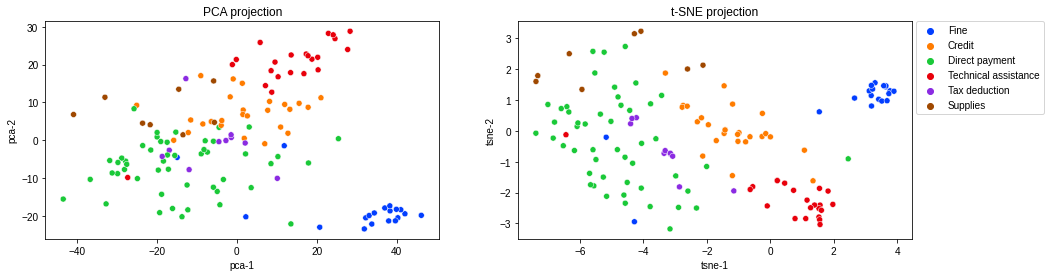

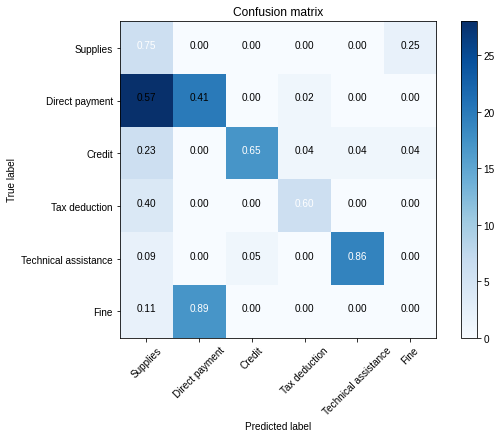

Macro/Weighted Avg F1-score: [0.5039263062518876, 0.5310994108286715]


In [28]:
grid_search_fine_tune_sbert(grid_search_params, train_sents, train_labels, test_sents, test_labels, label_names)

### Fine tuning with set parameters 

If you already know which configuration you want to fine tune SBERT on, and want to store the model, run these cells


In [29]:
fine_tuning_params = {
    "test_perc": 0.25,
    "model_names": 'paraphrase-xlm-r-multilingual-v1',
    "output_path": results_save_path,
    "experiment": experiment,
    "num_epochs": 2
}

Fine tuning parameters:
 {
    "test_perc": 0.25,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17",
    "experiment": "EXP17",
    "num_epochs": 2,
    "eval_classifier": "SBERT"
}



Evaluating:  22%|██▏       | 2/9 [00:00<00:00, 12.21it/s]


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 14.67it/s]



Evaluating:  22%|██▏       | 2/9 [00:00<00:00, 15.88it/s]


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 15.61it/s]



Time taken for fine-tuning: 00:00:28.31
Classifying sentences...


100%|██████████| 134/134 [00:05<00:00, 24.55it/s]


[t-SNE] Computing 133 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.000s...
[t-SNE] Computed neighbors for 134 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 14.717415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.891098
[t-SNE] KL divergence after 800 iterations: 0.149092


100%|██████████| 134/134 [00:00<00:00, 10800.09it/s]


Evaluating predictions...
Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.25_n-epoch=2_cm.png


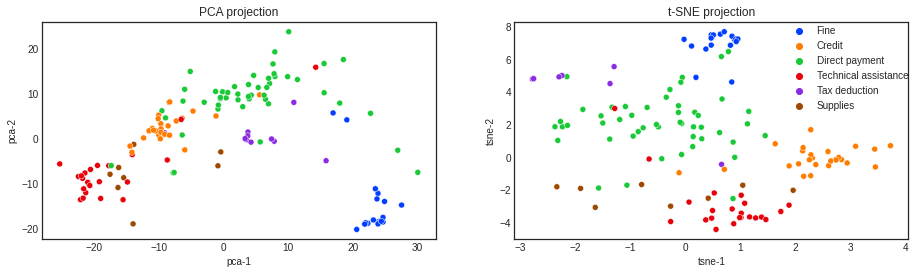

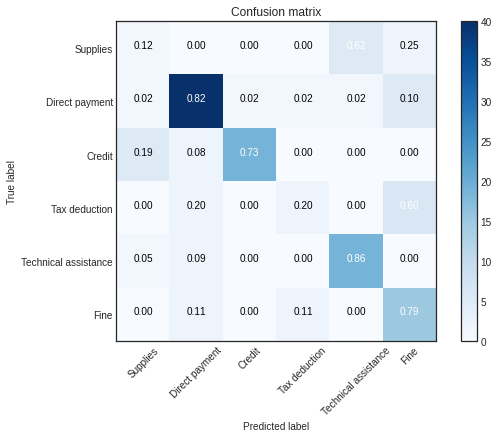

Macro/Weighted Avg F1-score: [0.5815507336446568, 0.7124790469199537]


In [32]:
fine_tune_sbert(fine_tuning_params, train_sents, train_labels, test_sents, test_labels, label_names)

## Initial ideas

### Something we can try out:
https://www.sbert.net/examples/training/data_augmentation/README.html#extend-to-your-own-datasets

### Links:
https://github.com/UKPLab/sentence-transformers/issues/350

https://omoindrot.github.io/triplet-loss


### Possible tasks for fine-tuning:
1) Given a pair of sentence embeddings, do they belong to the same category (binary)?

2) Given a sentence and a category embedding, does the sentence belong to the category (binary)?

3) Given a sentence embedding, use a classifier to predict its category (multiclass) [https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py](https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py)

4) Use a triplet loss approach such that sentences (texts) that have the same labels will become close in vector space, while sentences with a different label will be further away [https://github.com/UKPLab/sentencetransformers/blob/master/examples/training/other/training_batch_hard_trec_continue_training.py](https://github.com/UKPLab/sentencetransformers/blob/master/examples/training/other/training_batch_hard_trec_continue_training.py)
   
#### In this notebook **task number 3** is used to fine-tune the model.